For this project, we have to classify customers who have churned. Not only we will classify these customers but we will build a model that would make predictions.


The approach taken to this problem was to firstly define what churn is. This was defined by using the event of 'Cancellation Confirmation'. If the user cancelled their service, they were defined as churn.

After defining churn, some features were extracted such as gender and level. These features were used and a model was trained and it was used to make predictions. 

# INSTALLING SPARK

In [ ]:
!apt update > /dev/null
!apt install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 53.1 MB/s 


creating the working enviroment

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
# creating a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn Prediction") \
    .getOrCreate()

In [ ]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, udf, split, to_date, from_unixtime
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import unix_timestamp
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.mllib.util import MLUtils
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
% matplotlib inline

Loading the data

In [ ]:
sparkify_data = '/content/mini_sparkify_event_data.json'

In [ ]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [ ]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

Lets check the variables in our data

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Let's check the missing values in our data

In [ ]:
len(df.select(['userId','sessionId','artist','song']).where(df.userId == '').collect())

1101

In [ ]:
len(df.select(['userId','sessionId','artist','song']).where(df.sessionId.isNull()).collect())

0

In [ ]:
df = df.where(df.userId != '')

In [ ]:
df.count()

34497

In [ ]:
df.select(['userId', 'sessionId', 'artist']).where(df.gender == '').collect()

[]

In [ ]:
df.select(['userId', 'sessionId', 'artist']).where(df.gender.isNull()).collect()

[]

In [ ]:
df.select(['userId', 'sessionId', 'artist']).where(df.page == '').collect()

[]

As we can see, there were 1101 missing userId records in this dataset. For this, we removed the rows where these were missing.

In [ ]:
df.select('ts').show(2)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
+-------------+
only showing top 2 rows



time stamp to our date time coloumn

In [ ]:
df = df.withColumn('datetime', f.date_format(df.ts.cast(dataType=t.TimestampType()), "yyyy-MM-dd HH:mm:ss.SSS z"))

In [ ]:
df.filter(df.sessionId == '141').select(['artist','length','sessionId','datetime','firstname','itemInSession','song','userId']).show()

+--------------------+---------+---------+--------------------+---------+-------------+--------------------+------+
|              artist|   length|sessionId|            datetime|firstname|itemInSession|                song|userId|
+--------------------+---------+---------+--------------------+---------+-------------+--------------------+------+
|                null|     null|      141|+50719-01-27 21:1...|    Grant|            0|                null|   142|
|           The Kooks|169.45587|      141|+50719-01-28 03:0...|    Grant|            1|         Love It All|   142|
|          Plasmatics| 256.7571|      141|+50719-01-30 01:5...|    Grant|            2|          The Damned|   142|
|     Alliance Ethnik|195.94404|      141|+50719-02-02 01:0...|    Grant|            3|SinceritÃÂ© Et J...|   142|
|     Tears For Fears|361.29914|      141|+50719-02-04 07:1...|    Grant|            4|              Change|   142|
|                  B5|189.36118|      141|+50719-02-08 11:3...|    Grant

This dataframe has null values, we will fill it with zero.


In [ ]:
df = df.fillna({'length':0})

# Exploratory Data Analysis

we will perform EDA by loading a small subset of the data and doing basic manipulations within Spark.

Once we've done some preliminary analysis, we create a column Churn to use as the label for your model.

Once we've defined churn, we perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

dropping duplicates

In [ ]:
df.select('page').dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



Explorig how many users are actually on the system, and how many have went on the page 'Cancellation Confirmation'

In [ ]:


# groupby user and also by cancellation confirmation
print("Cancel Confirmation Total Count: ", df.filter(df['page'] == 'Cancellation Confirmation').count())

# how many users are on the system?
print("Users on the system: ", len(df.select('userId').dropDuplicates().collect()))


print("Cancel confirmation users: ", len(df.select('userId').filter(df['page'] == 'Cancellation Confirmation').collect()))

Cancel Confirmation Total Count:  2
Users on the system:  126
Cancel confirmation users:  2


Above, we can confirm that 2 users have cancelled the service. We can also confirm that 126 users are using the service. These are all unique users on the system. 

creating a column called Churn and 1 being if the user ever had a Cancellation Confirmation and 0 if not

In [ ]:

flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df = df.withColumn("churned", flag_churn("page"))

In [ ]:
df.select(['userId', 'churned']).where(df.churned == 1).count()

2

collecting all user Id's that are churned

In [ ]:

userIds = []
for userId in df.filter(df.churned == 1).select('userId').collect():
    userIds.append(userId[0])

In [ ]:
flag_churn_2 = udf(lambda x: 1 if x in (userIds) else 0, IntegerType())

In [ ]:
df = df.withColumn("churned", flag_churn_2("userId"))

In [ ]:
df.where(df.churned == 1).count()

621

In [ ]:
df.groupby(['churned','page']).agg({'page':'count'}).orderBy('page').show()

+-------+--------------------+-----------+
|churned|                page|count(page)|
+-------+--------------------+-----------+
|      1|               About|          1|
|      0|               About|         51|
|      0|          Add Friend|        497|
|      1|          Add Friend|         10|
|      1|     Add to Playlist|         21|
|      0|     Add to Playlist|        783|
|      1|              Cancel|          2|
|      1|Cancellation Conf...|          2|
|      1|           Downgrade|          5|
|      0|           Downgrade|        218|
|      0|               Error|         39|
|      0|                Help|        183|
|      1|                Help|          1|
|      0|                Home|       1334|
|      1|                Home|         22|
|      1|              Logout|          8|
|      0|              Logout|        415|
|      1|            NextSong|        509|
|      0|            NextSong|      27602|
|      0|         Roll Advert|        731|
+-------+--

In [ ]:
page_grouped = df.groupby(['churned','page']).agg({'page':'count'}).orderBy('page').toPandas()

removing 'cancel' and 'cancel confirmation' as it is not in the churned 0 df

Let's visualize a bar graph for better understanding

In [ ]:

page_grouped = page_grouped[(page_grouped.page != 'Cancel')]
page_grouped = page_grouped[(page_grouped.page != 'Cancellation Confirmation')]

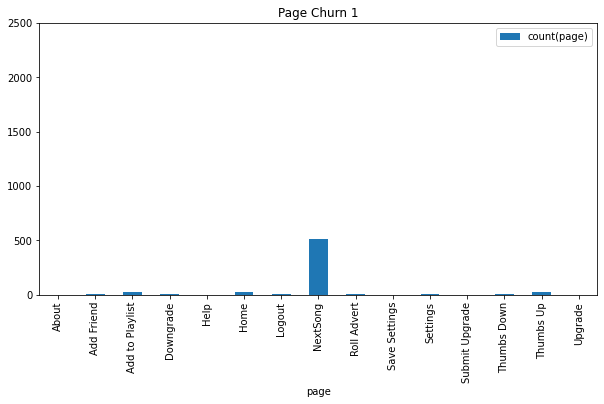

In [ ]:
page_grouped[page_grouped.churned == 1].set_index('page').drop('churned', axis=1).plot(kind='bar',
                                                                                       figsize=(10,5),
                                                                                      title='Page Churn 1',
                                                                                      ylim=(0,2500));

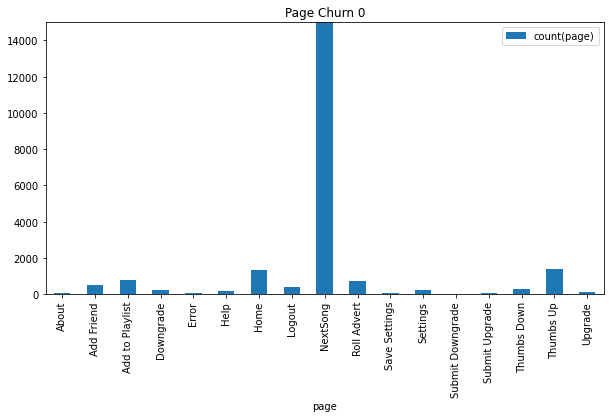

In [ ]:
page_grouped[page_grouped.churned == 0].set_index('page').drop('churned', axis=1).plot(kind='bar',
                                                                                       figsize=(10,5),
                                                                                      title='Page Churn 0',
                                                                                      ylim=(0,15000));

From we can see with our findings, churn 0 has more counts because of the distribution. However, we can see that other statistics are basically the same in comparison with each other.

In [ ]:
df.groupby(['userId','sessionId']).count().orderBy('count', ascending=False).show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|   115|      316| 1080|
|   101|      635|  847|
|    61|      529|  637|
|    51|      236|  599|
|   141|      479|  538|
|    29|      617|  510|
|   124|      420|  456|
|    51|      442|  434|
|     2|        1|  428|
|   101|      496|  423|
|    15|      591|  413|
|    39|      619|  402|
|    17|      602|  377|
|    54|      670|  362|
|   142|      498|  361|
|    58|      579|  331|
|   142|      565|  328|
|   140|      644|  323|
|    95|      398|  321|
|    49|      182|  320|
+------+---------+-----+
only showing top 20 rows



we can see the amount of actions or pages that a user would have been on at one time. For example, we can see that user 115 is the highest, which would mean they were on the site for 1080 actions. This means that they could have been playing songs, or other actions.

In [ ]:
df.where(df.page == 'NextSong').groupby(['userId','churned']).count().orderBy('count', ascending=False).show()


+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|   101|      0| 1501|
|    51|      0| 1378|
|    95|      0|  965|
|   115|      0|  925|
|    54|      0|  924|
|   124|      0|  921|
|   140|      0|  867|
|   142|      0|  863|
|    39|      0|  845|
|    15|      0|  843|
|    29|      0|  798|
|    61|      0|  765|
|    58|      0|  686|
|    92|      0|  625|
|   141|      0|  574|
|   100|      0|  514|
|   105|      0|  487|
|    42|      0|  485|
|    12|      0|  462|
|    70|      0|  455|
+------+-------+-----+
only showing top 20 rows



In [ ]:
df.where(df.page == 'NextSong').groupby(['userId','churned']).count().orderBy('count', ascending=True).show()

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|    62|      0|    1|
|   122|      0|    5|
|    60|      0|    6|
|    68|      0|    6|
|   135|      0|    6|
|   128|      0|    7|
|   119|      0|    8|
|   147|      0|   11|
|   134|      0|   12|
|    89|      0|   12|
|    55|      0|   12|
|   138|      0|   14|
|     5|      0|   16|
|     7|      0|   16|
|    50|      0|   18|
|    34|      0|   20|
|   114|      0|   20|
|    94|      0|   21|
|    37|      0|   21|
|    41|      0|   22|
+------+-------+-----+
only showing top 20 rows



we look at the reverse, there are more who have churned. This just gives some evidence that persons who have churned play less songs than those who have not. This is not conclusive, but shows that it may be helpful in being a feature.


Above the users with the most songs played and showing whether they have churned or not. We can see for the top users the majority have not churned.

# Feature Engineering

Now that we are familiarized with the data, we build out the features we find promising to train our model on. To work with the full dataset, we follow the following steps.






1.Write a script to extract the necessary features from the smaller subset of data

2.Ensure that our script is scalable.

3.Try our script on the full data set, debugging our script if necessary















**Columns to be used:**

Gender: string (M/F)

Length

Level (Paid/Free)

Page: Has to be explored more because there are a number of categories in here to use.

NextSong: create a udf so that it can show the amount of nextSongs played.

In [ ]:
male_female = udf(lambda x: 1 if x == "M" else 0, IntegerType())
paid_free = udf(lambda x: 1 if x == "Paid" else 0, IntegerType())
next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

In [ ]:
# df = df.withColumn('male_female', male_female('gender'))
# df = df.withColumn('paid_free', paid_free('level'))
df = df.withColumn('next_song', next_song('page'))

In [ ]:
# lets use string index for the gender
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='gender', outputCol='genderCatIndex')
df = indexer.fit(df).transform(df)
df.groupby('genderCatindex').count().show()

+--------------+-----+
|genderCatindex|count|
+--------------+-----+
|           0.0|17310|
|           1.0|17187|
+--------------+-----+



In [ ]:
# use StringIndexer on page column
level_indexer = StringIndexer(inputCol='page', outputCol='pageCatIndex')
df = level_indexer.fit(df).transform(df)
df.groupby('pageCatIndex').count().show()

+------------+-----+
|pageCatIndex|count|
+------------+-----+
|         8.0|  223|
|         0.0|28111|
|         7.0|  269|
|        18.0|    2|
|         1.0| 1384|
|         4.0|  734|
|        11.0|  113|
|        14.0|   39|
|         3.0|  804|
|         2.0| 1356|
|        17.0|    2|
|        10.0|  184|
|        13.0|   46|
|         6.0|  423|
|         5.0|  507|
|        15.0|   34|
|         9.0|  206|
|        16.0|    8|
|        12.0|   52|
+------------+-----+



In [ ]:
# lets use string index for the gender
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='level', outputCol='levelCatIndex')
df = indexer.fit(df).transform(df)
df.groupby('levelCatindex').count().show()

+-------------+-----+
|levelCatindex|count|
+-------------+-----+
|          0.0|22480|
|          1.0|12017|
+-------------+-----+



Downsampling the dataset to balance churn.

In [ ]:
df.groupby('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|  621|
|      0|33876|
+-------+-----+



Here is the imbalance of churn. 621:33876.

In [ ]:
churn = df.groupby(['churned']).agg({'churned':'count'}).toPandas()

In [ ]:
churn

,churned,count(churned)
0,1,621
1,0,33876


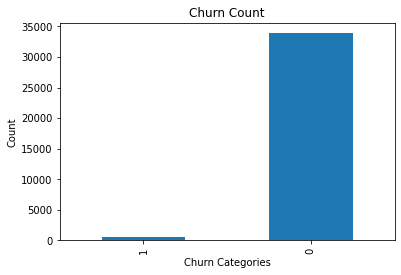

In [ ]:
ax = churn.set_index('churned').plot(kind='bar', title='Churn Count', legend=False);
ax.set_xlabel("Churn Categories");
ax.set_ylabel("Count");

The distribution for Churn is very unbalanced. This can really throw off the modeling so we will balance this.

In [ ]:
df.sampleBy('churned', fractions={0:621/33876, 1:1.0}).groupby('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|  621|
|      0|  629|
+-------+-----+



In [ ]:
df_balance = df.sampleBy('churned', fractions={0:621/33876, 1:1.0})

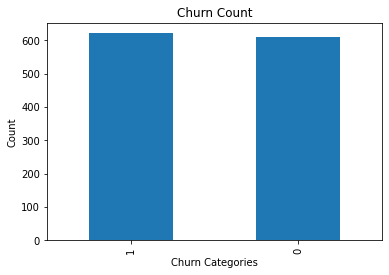

In [ ]:
churn_balanced = df_balance.groupby(['churned']).agg({'churned':'count'}).toPandas()
ax = churn_balanced.set_index('churned').plot(kind='bar', title='Churn Count', legend=False);
ax.set_xlabel("Churn Categories");
ax.set_ylabel("Count");

We downsampled the dataset so that the churn category can be more balanced.

There might be correlation between users who churn and the amount of time they are playing songs

In [ ]:

df_balance.groupby(['userId', 'churned', 'level']).sum('length').orderBy('sum(length)', ascending=True).show()

+------+-------+-----+-----------+
|userId|churned|level|sum(length)|
+------+-------+-----+-----------+
|   113|      0| free|        0.0|
|    58|      0| free|        0.0|
|    13|      0| free|        0.0|
|    14|      0| paid|        0.0|
|    65|      0| free|        0.0|
|    50|      0| free|        0.0|
|   132|      0| free|        0.0|
|   106|      0| free|        0.0|
|    60|      0| free|        0.0|
|   129|      0| free|        0.0|
|   126|      0| free|        0.0|
|   112|      0| free|        0.0|
|    17|      0| free|        0.0|
|   127|      0| paid|   50.85995|
|    30|      0| free|  106.05669|
|    97|      0| free|  122.04363|
|   131|      0| free|  156.65587|
|    45|      0| free|  157.28281|
|   148|      0| free|  158.45832|
|    42|      0| free|  163.47383|
+------+-------+-----+-----------+
only showing top 20 rows



As seen above, there is about 5 times more persons who did not churned compared to those who have churned. This creates a problem with the models and accuracy. As we have seen, there were no churn predictions because of this. To remedy this we had to downsample. We used the sampleBy method and now there is more of a 1:1 ratio although we lost many records.

# Building our model

In [ ]:
df_balance_training = df_balance_output.select(col('churned').alias('label'), col('features'))

In [ ]:
assembler = VectorAssembler(inputCols=['genderCatIndex', 'pageCatIndex', 'levelCatIndex'], outputCol="features")
df_balance_output = assembler.transform(df_balance)

Below two functions will be created. a training model and score function which will show the scores in for the given model.

In [ ]:
def train_model(df, model='lr'):
    """
    Train a model and return predictions on test dataset
    Args: 
        df: Dataframe
        model: default is Logistic Regressions
            options: 'rf': Random Forest Classifier
                     'dt': Decision Tree Classifier
        return: predictions dataframe containing `label`
    """
    results = None
    
    assembler = VectorAssembler(inputCols=['genderCatIndex', 'pageCatIndex', 'levelCatIndex'], outputCol="features")
    df = assembler.transform(df)
    
    # rename column to label
    df = df.withColumnRenamed('churned', 'label')
    
    train, test = df.randomSplit([0.8, 0.2])
    
    if model == 'lr':
        model = LogisticRegression(maxIter=80, regParam=0.3, elasticNetParam=0.0)
    if model == 'rf':
        model = RandomForestClassifier()
    if model == 'dt':
        model = DecisionTreeClassifier(maxDepth=3)
    
    model = model.fit(train)
    
    # return predictions
    results = model.transform(test)
    
    return results
    

In [ ]:
def scores(df):
    df = df.toPandas()
    
    print("Accuracy Score: ", accuracy_score(df.label, df.prediction))
    print("F1 Score: ", f1_score(df.label, df.prediction))

# Logistic Regression

In [ ]:
predictions = train_model(df_balance)

In [ ]:
scores(predictions)

Accuracy Score:  0.7867647058823529
F1 Score:  0.8066666666666668


# Random Forest Classifier

In [ ]:
predictions_rf = train_model(df_balance, model='rf')

In [ ]:
scores(predictions_rf)

Accuracy Score:  0.8007968127490039
F1 Score:  0.8201438848920863


# Decision Tree Classifier

In [ ]:
predictions_dt = train_model(df_balance, model='dt')
scores(predictions_dt)

Accuracy Score:  0.7754237288135594
F1 Score:  0.792156862745098


Let's check our model scores

In [ ]:
print("******Model Scores******")
print("Logistic Regression")
print(scores(predictions))
print("Random Forest Classifier")
print(scores(predictions_rf))
print("Decision Tree Classifier")
print(scores(predictions_dt))

******Model Scores******
Logistic Regression
Accuracy Score:  0.7877551020408163
F1 Score:  0.7936507936507937
None
Random Forest Classifier
Accuracy Score:  0.8007968127490039
F1 Score:  0.8201438848920863
None
Decision Tree Classifier
Accuracy Score:  0.7754237288135594
F1 Score:  0.792156862745098
None


# Let's try to improve our model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
training, testing = df_balance.randomSplit([0.8, 0.2])

In [ ]:
training = training.withColumnRenamed('churned', 'label')
testing = testing.withColumnRenamed('churned', 'label')

In [ ]:
indexer = StringIndexer(inputCol='gender', outputCol='genderCatIndex')
level_indexer = StringIndexer(inputCol='page', outputCol='pageCatIndex')
si = StringIndexer(inputCol='level', outputCol='levelCatIndex')
assembler = VectorAssembler(inputCols=['genderCatIndex', 'pageCatIndex', 'levelCatIndex'], outputCol="features")
logistic_r = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0, labelCol='label')

pipeline = Pipeline(stages=[assembler, logistic_r])

In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(logistic_r.regParam, [0.1, 0.01, 0.5, 0.9])\
    .addGrid(logistic_r.fitIntercept, [True, False])\
    .addGrid(logistic_r.maxIter, [1,10,100])\
    .addGrid(logistic_r.threshold, [0.5, 0.1, 0.8])\
    .build()


crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

model = crossval.fit(training)

preds = model.transform(testing)

In [ ]:
preds.filter(preds.label == preds.prediction).count() / preds.count()

0.7466666666666667

In [ ]:
scores(preds)

Accuracy Score:  0.7466666666666667
F1 Score:  0.774703557312253


The accuracy score of the using the Logistic Regression training model was 77%.

Overall, this score was ok, but it could be improved. This could possibly be done by extracting more features.